In [1]:
import yaml
import torch
import time
import numpy as np

from models import EdgeGNN, GAT, GCN, GraphSAGE, GIN, NodeEdgeGNN, SWEGNN
from data import FloodingEventDataset
from training import NodeRegressionTrainer, EdgeRegressionTrainer

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
np.random.seed(42)
torch.manual_seed(42)

In [4]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

In [5]:
dataset, info = FloodingEventDataset(node_features=config['node_features'],
                    edge_features=config['edge_features'],
                    debug=True,
                    **config['dataset_parameters']).load()

Loading data from the following files:
	Graph Metadata Filepath:  data/graph_metadata.yaml
	Feature Metadata Filepath:  data/feature_metadata.yaml
	HEC-RAS HDF Filepath:  data/datasets/Model_01.p01.hdf
	Nodes SHP Filepath:  data/datasets/geometry/cell_centers.shp
	Edges SHP Filepath:  data/datasets/geometry/links.shp
Graph properties:
	Timesteps: 337
	Edge Index: torch.Size([2, 2612])
	Pos: torch.Size([2, 1268])
Successfully loaded for node_features:
	static (Shape: torch.Size([1268, 3])):
		area: (1268,)
		roughness: (1268,)
		elevation: (1268,)
	dynamic (Shape: torch.Size([337, 1268, 1])):
		water_level: (337, 1268)
Successfully loaded for edge_features:
	static (Shape: torch.Size([2612, 5])):
		direction_x: (2612,)
		direction_y: (2612,)
		face_length: (2612,)
		length: (2612,)
		slope: (2612,)
	dynamic (Shape: torch.Size([337, 2612, 1])):
		velocity: (337, 2612)
Expected node_features format:
	[
		area (static)
		roughness (static)
		elevation (static)
		water_level t-2 (dynamic)
	

In [6]:
num_train = int(len(dataset) * 0.8) # 80% train, 20% test

train_dataset = dataset[:num_train]
# train_loader = DataLoader(train_dataset) # batch_size=32, shuffle=True

test_dataset = dataset[num_train:]
# test_loader = DataLoader(test_dataset) # batch_size=32, shuffle=True

In [7]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
base_model_params = {
    'static_node_features': info['num_static_node_features'],
    'dynamic_node_features': info['num_dynamic_node_features'],
    'static_edge_features': info['num_static_edge_features'],
    'dynamic_edge_features': info['num_dynamic_edge_features'],
    'previous_timesteps': info['previous_timesteps'],
    'device': device,
}
lr_info = config['training_parameters']

## Node Prediction Models

In [8]:
node_model_map = {
    'SWEGNN': SWEGNN,
    'GCN': GCN,
    'GAT': GAT,
    'GIN': GIN,
    'GraphSAGE': GraphSAGE,
}

In [9]:
model_name = 'GIN' # Choose from the ff: SWEGNN, GCN, GAT, GIN, GraphSAGE
model_params = config['model_parameters'][model_name]
model = node_model_map[model_name](**model_params, **base_model_params)

num_epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=lr_info['learning_rate'], weight_decay=lr_info['weight_decay'])
loss_func = torch.nn.L1Loss()

trainer = NodeRegressionTrainer(train_dataset=train_dataset, val_dataset=test_dataset, model=model,
                                loss_func=loss_func, optimizer=optimizer, num_epochs=num_epochs, device=device)
trainer.train()
trainer.validate()

Epoch [1/10], Training Loss: 44.1398
Epoch [2/10], Training Loss: 0.0206
Epoch [3/10], Training Loss: 0.0206
Epoch [4/10], Training Loss: 0.0206
Epoch [5/10], Training Loss: 0.0206
Epoch [6/10], Training Loss: 0.0206
Epoch [7/10], Training Loss: 0.0206
Epoch [8/10], Training Loss: 0.0206
Epoch [9/10], Training Loss: 0.0206
Epoch [10/10], Training Loss: 0.0206


Final training Loss: 0.0206
Average training Loss: 4.4325
Minimum training Loss: 0.0206
Maximum training Loss: 44.1398
Total training time: 6.3741 seconds
Validation Loss: 0.0027
Inference time: 0.084074 seconds


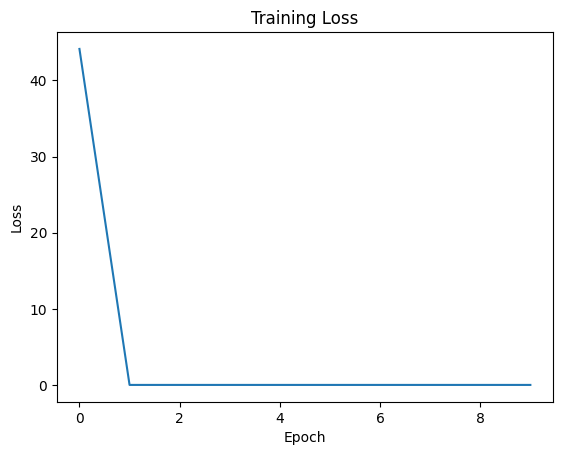

In [10]:
stats = trainer.get_stats()
stats.print_stats_summary()
stats.plot_train_loss()

## Edge Prediction Models

In [11]:
edge_model_map = {
    'EdgeGNN': EdgeGNN,
}

In [12]:
model_name = 'EdgeGNN' # Choose from the ff: EdgeGNN
model_params = config['model_parameters'][model_name]
model = edge_model_map[model_name](**model_params, **base_model_params)

num_epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=lr_info['learning_rate'], weight_decay=lr_info['weight_decay'])
loss_func = torch.nn.L1Loss()

trainer = EdgeRegressionTrainer(train_dataset=train_dataset, val_dataset=test_dataset, model=model,
                                loss_func=loss_func, optimizer=optimizer, num_epochs=num_epochs, device=device)
trainer.train()
trainer.validate()

Epoch [1/10], Training Loss: 18.2934
Epoch [2/10], Training Loss: 0.1554
Epoch [3/10], Training Loss: 0.1539
Epoch [4/10], Training Loss: 0.1537
Epoch [5/10], Training Loss: 0.1536
Epoch [6/10], Training Loss: 0.1536
Epoch [7/10], Training Loss: 0.1536
Epoch [8/10], Training Loss: 0.1535
Epoch [9/10], Training Loss: 0.1535
Epoch [10/10], Training Loss: 0.1535


Final training Loss: 0.1535
Average training Loss: 1.9678
Minimum training Loss: 0.1535
Maximum training Loss: 18.2934
Total training time: 9.7403 seconds
Validation Loss: 0.1074
Inference time: 0.087692 seconds


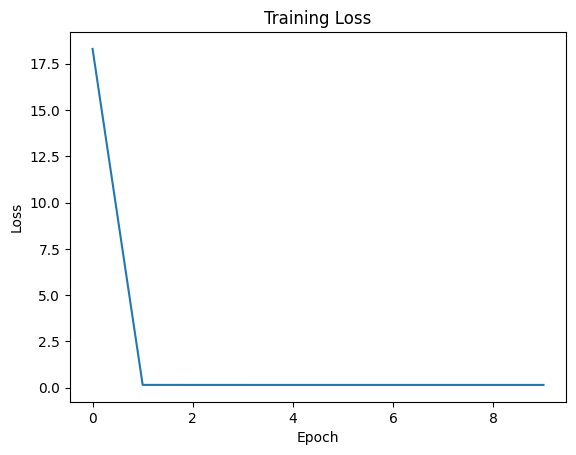

In [13]:
stats = trainer.get_stats()
stats.print_stats_summary()
stats.plot_train_loss()

## Self-Supervised Learning Methods

In [ ]:
from tqdm import tqdm
from models.graph_mae2 import GraphMAE2
from utils.graph_mae2_utils import LinearRegression

In [ ]:
dataset, info = FloodingEventDataset(node_features=config['node_features'],
                    edge_features=config['edge_features'],
                    **config['dataset_parameters']).load()

print(len(dataset))
print(dataset[0])
print(type(dataset[0].x), dataset[0].x.shape)
print(type(dataset[0].edge_index), dataset[0].edge_index.shape)
print(type(dataset[0].edge_attr), dataset[0].edge_attr.shape)
print(type(dataset[0].y), dataset[0].y.shape)
print(info)

336
Data(x=[1268, 6], edge_index=[2, 5224], edge_attr=[5224, 8], y=[1268, 1], pos=[2, 1268])
<class 'torch.Tensor'> torch.Size([1268, 6])
<class 'torch.Tensor'> torch.Size([2, 5224])
<class 'torch.Tensor'> torch.Size([5224, 8])
<class 'torch.Tensor'> torch.Size([1268, 1])
{'num_static_node_features': 3, 'num_dynamic_node_features': 1, 'num_static_edge_features': 5, 'num_dynamic_edge_features': 1, 'previous_timesteps': 2}


In [ ]:
num_train = int(len(dataset) * 0.8) # 80% train, 20% test

train_dataset = dataset[:num_train]
# train_loader = DataLoader(train_dataset) # batch_size=32, shuffle=True

test_dataset = dataset[num_train:]
# test_loader = DataLoader(test_dataset) # batch_size=32, shuffle=True

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
base_model_params = {
    'static_node_features': info['num_static_node_features'],
    'dynamic_node_features': info['num_dynamic_node_features'],
    'static_edge_features': info['num_static_edge_features'],
    'dynamic_edge_features': info['num_dynamic_edge_features'],
    'previous_timesteps': info['previous_timesteps'],
    'device': device,
}
lr_info = config['training_parameters']
model_info = config['model_parameters']

In [ ]:
def pretrain(model, dataset, optimizer):
    start_time = time.time()

    max_epoch = 20
    epoch_iter = tqdm(range(max_epoch))
    model.to(device)
    for epoch in epoch_iter:
        model.train()
        running_loss = 0.0

        for graph in dataset:
            graph = graph.to(device)
            x = graph.x # Target
            target_nodes = torch.arange(x.shape[0], device=device, dtype=torch.long)

            optimizer.zero_grad()

            loss = model(graph, x, targets=target_nodes)
            running_loss += loss.item()

            loss.backward()
            optimizer.step()

        epoch_loss = running_loss / num_train
        epoch_iter.set_description(f"# Epoch {epoch}: train_loss: {epoch_loss:.4f}")

    end_time = time.time()
    print(f'Total pre-training time: {(end_time - start_time):4f} seconds')
    return model

def linear_probing(model, dataset, in_dim, out_dim, lr_f, weight_decay_f):
    start_time = time.time()

    decoder = LinearRegression(in_dim, out_dim).to(device)

    num_finetune_params = [p.numel() for p in decoder.parameters() if  p.requires_grad]
    print(f"num parameters for finetuning: {sum(num_finetune_params)}")

    loss_f = torch.nn.MSELoss()
    optimizer_f = torch.optim.Adam(decoder.parameters(), lr=lr_f, weight_decay=weight_decay_f)

    best_model = None
    max_epoch_f = 50
    epoch_iter_f = tqdm(range(max_epoch_f))
    model.eval()
    decoder.train()
    for epoch in epoch_iter_f:
        running_loss = 0.0

        for graph in dataset:
            optimizer_f.zero_grad()

            graph = graph.to(device)
            with torch.no_grad():
                x = model.embed(graph)
                x = x.to(device)
            label = graph.y

            out = decoder(x)
            loss = loss_f(out, label)

            loss.backward()
            optimizer_f.step()
            running_loss += loss.item()

        epoch_loss = running_loss / num_train
        epoch_iter_f.set_description(f"# Epoch {epoch}: train_loss: {epoch_loss:.4f}")

    end_time = time.time()
    print(f'Final loss: {epoch_loss:4f}')
    print(f'Total fine-tuning time: {(end_time - start_time):4f} seconds')

    return decoder

def test_ssl(model, ft_model, dataset, loss_func):
    start_time = time.time()
    model.eval()
    ft_model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for graph in dataset:
            graph = graph.to(device)
            x = model.embed(graph)
            labels = graph.y

            outputs = ft_model(x)

            loss = loss_func(outputs, labels)
            running_loss += loss.item()
    end_time = time.time()

    # Print validation statistics
    print(f'Validation Loss: {running_loss:.4f}')
    print(f'Inference time: {end_time - start_time} seconds')

In [ ]:
graphmae2_params = model_info['GRAPHMAE2']
in_dim = dataset[0].x.shape[1]
model = GraphMAE2(in_dim=in_dim, **graphmae2_params)
optimizer = torch.optim.Adam(model.parameters(), lr=lr_info['learning_rate'], weight_decay=lr_info['weight_decay'])

trained_model = pretrain(model, train_dataset, optimizer)

=== Use sce_loss and alpha_l=3 ===


# Epoch 19: train_loss: 0.0224: 100%|██████████| 20/20 [01:35<00:00,  4.77s/it]

Total pre-training time: 95.315137 seconds


In [ ]:
out_dim = dataset[0].y.shape[1]
hidden_dim = graphmae2_params['num_hidden'] // graphmae2_params['nhead']
ft_model = linear_probing(trained_model, train_dataset, hidden_dim, out_dim, 0.0008, lr_info['weight_decay'])

num parameters for finetuning: 2177


# Epoch 49: train_loss: 620.0525: 100%|██████████| 50/50 [00:56<00:00,  1.13s/it] 

Final loss: 620.052530
Total fine-tuning time: 56.627321 seconds


In [ ]:
loss_func = torch.nn.L1Loss()
test_ssl(trained_model, ft_model, test_dataset, loss_func)

Validation Loss: 32728.5642
Inference time: 0.2315971851348877 seconds


In [ ]:
from models.gine.pretrain_contextpred import main

model_file = 'models/gine/trained_model/gine_pretrain'
main(model_file)


cbow
num layer: 5 l1: 4 l2: 7
6
6
6
6
6
====epoch 1


Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([12894, 6])
torch.Size([12894, 1])


Iteration:   0%|          | 0/2 [00:20<?, ?it/s]


RuntimeError: running_mean should contain 1 elements not 6